# Challenge: Housing Market

## By Jean-Philippe Pitteloud

### Requirements

In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Data Gathering

In order to complete this assignment, a dataset was retrieved from the Thinkful PostgreSQL database using the following values:

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_df = pd.read_sql_query('select * from houseprices',con = engine)

engine.dispose()


house_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


Once the dataset was read as a Pandas dataframe, an evaluation about the nature of the dataset was conducted programmatically and summary statistics for the numerica variables calculated

In [3]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [4]:
house_df.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


As it can be seen fromn the tables above, the working dataset consists of 1460 records and 81 columns, and while most of the variables/columns are quite complete several others report missing values. In ordet to get a better picture about the distribution of numeric and categorical variables in the dataset, the following exploration was conducted

In [5]:
num_cols = house_df.describe().columns
print('These are the categorical variables:\n {}'.format(num_cols))
print('\n There are {} numeric variables in the dataset'.format(len(num_cols)))

These are the categorical variables:
 Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')

 There are 38 numeric variables in the dataset


In terms of numeric variables, the presents 38 columns out of 81 formatted as either 'int' or 'float'

In [6]:
cat_cols = house_df.select_dtypes(['object']).columns
print('These are the categorical variables:\n {}'.format(cat_cols))
print('\n There are {} categorical variables in the dataset'.format(len(cat_cols)))

These are the categorical variables:
 Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')

 There are 43 categorical variables in the dataset


From the available 81 columns only 43 are formatted as 'string' or 'object', implying a categorical nature for them

### Data Cleaning

Since the goal of this work is to develop a model that can predict the sale price of houses based on the available variables, the distribution of the target variable 'saleprice' in our dataset was explored. As it can be seen in the plot below, the values in the 'saleprice' variable are not normally distributed and the distribution is skewed to the right with few data points with extremely high values and the majority of the data points concentrated in the lower end of the sale prices

In [7]:
house_df_clean = house_df.copy()

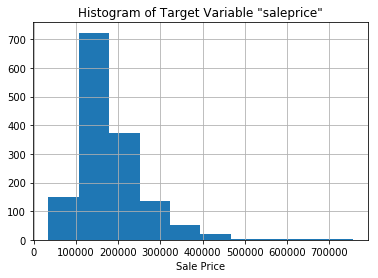

In [8]:
house_df_clean.saleprice.hist()
plt.title('Histogram of Target Variable "saleprice"')
plt.xlabel('Sale Price');

Since our preliminary observations indicated that several columns report missing values, a more detailed exploration was performed using the proportion of missing records in each variables as key metric. In the table below, a list of all numeric variables in the dataset along with the proportion of missing values is presented. Taking into consideration the description of the data in each variable below and the proportion of missing values, the variables 'garageyrblt', 'masvnrarea', and 'lotfrontage' were removed from our working dataset

In [9]:
(house_df_clean[num_cols].isnull().sum() / house_df_clean.shape[0]).sort_values(ascending = False)

lotfrontage      0.177397
garageyrblt      0.055479
masvnrarea       0.005479
bsmtfinsf1       0.000000
lowqualfinsf     0.000000
secondflrsf      0.000000
firstflrsf       0.000000
totalbsmtsf      0.000000
bsmtunfsf        0.000000
bsmtfinsf2       0.000000
saleprice        0.000000
bsmtfullbath     0.000000
yearremodadd     0.000000
yearbuilt        0.000000
overallcond      0.000000
overallqual      0.000000
lotarea          0.000000
mssubclass       0.000000
grlivarea        0.000000
bsmthalfbath     0.000000
yrsold           0.000000
fullbath         0.000000
mosold           0.000000
miscval          0.000000
poolarea         0.000000
screenporch      0.000000
threessnporch    0.000000
enclosedporch    0.000000
openporchsf      0.000000
wooddecksf       0.000000
garagearea       0.000000
garagecars       0.000000
fireplaces       0.000000
totrmsabvgrd     0.000000
kitchenabvgr     0.000000
bedroomabvgr     0.000000
halfbath         0.000000
id               0.000000
dtype: float

In [10]:
house_df_clean = house_df_clean.drop(['garageyrblt', 'masvnrarea', 'lotfrontage'], axis = 1)

A similar evaluation of missing values was conducted on the categorical variables available in our dataset, and the results presented below

In [11]:
(house_df_clean[cat_cols].isnull().sum() / house_df_clean.shape[0]).sort_values(ascending = False)

poolqc           0.995205
miscfeature      0.963014
alley            0.937671
fence            0.807534
fireplacequ      0.472603
garagecond       0.055479
garagequal       0.055479
garagefinish     0.055479
garagetype       0.055479
bsmtfintype2     0.026027
bsmtexposure     0.026027
bsmtfintype1     0.025342
bsmtqual         0.025342
bsmtcond         0.025342
masvnrtype       0.005479
electrical       0.000685
condition2       0.000000
condition1       0.000000
neighborhood     0.000000
landslope        0.000000
bldgtype         0.000000
landcontour      0.000000
lotconfig        0.000000
utilities        0.000000
roofstyle        0.000000
lotshape         0.000000
street           0.000000
housestyle       0.000000
salecondition    0.000000
roofmatl         0.000000
exterior1st      0.000000
exterior2nd      0.000000
exterqual        0.000000
extercond        0.000000
foundation       0.000000
saletype         0.000000
heating          0.000000
heatingqc        0.000000
centralair  

From the summary tabelo above, the first five variables report numbers of missing values ranging from 47% to 99.5%, making any effort to input them very cumbersome and uncertain. For this reason, the features 'poolqc', 'miscfeature', 'alley', 'fence', and 'fireplacequ' were removed from our working dataset. Regarding the remaining categorical variables reporting missing values, an more detailed evaluation is needed. For example, variables such as 'garagecond', 'garagequal', 'garagefinish', and 'garagetype' are all related to "garage" and report around 5.5% missing records, therefore an investigation into the records missing this particular information might be useful

In [12]:
house_df_clean = house_df_clean.drop(['poolqc', 'miscfeature', 'alley', 'fence', 'fireplacequ'], axis = 1)

First, an investigation on the records with missing information in the mentioned columns was conducted to confirm that the missing values were all reported from the same records. As it can be seen in the code below, the records reporting missing values are the same for all the mentioned variables. The next step in our investigation to decide the best course of action to address these missing values, is to see whether they are distributed randomly around the sample and not belonging to any specific price range 

In [13]:
mask1 = (house_df_clean['garagecond'].isna()) & (house_df_clean['garagequal'].isna()) & (house_df_clean['garagefinish'].isna()) & (house_df_clean['garagetype'].isna())
all_g = house_df_clean.loc[mask1, :]

mask2 = (house_df_clean['garagecond'].isna()) | (house_df_clean['garagequal'].isna()) | (house_df_clean['garagefinish'].isna()) | (house_df_clean['garagetype'].isna())
any_g = house_df_clean.loc[mask2, :]

all_g.equals(any_g)

True

In [14]:
house_df_clean.saleprice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: saleprice, dtype: float64

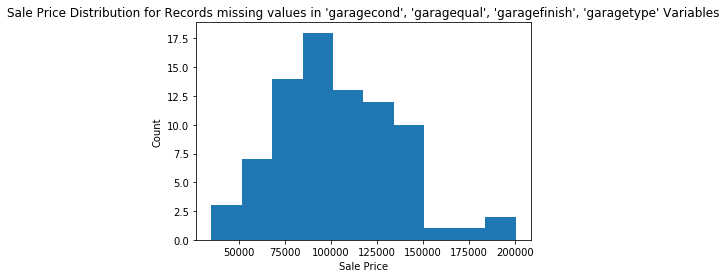

In [15]:
plt.hist(all_g['saleprice'])
plt.title("Sale Price Distribution for Records missing values in 'garagecond', 'garagequal', 'garagefinish', 'garagetype' Variables")
plt.xlabel('Sale Price')
plt.ylabel('Count');

From the table and histogram presented above, it can be seen that the missing records in the variables related to "garage" are distributed across a wide range of sale prices from below \\$ 50,000 to around \\$200,000. This range covers around 75% of the records in the dataset. For these reasons the records containing missing values in the columnns, 'garagecond', 'garagequal', 'garagefinish', and 'garagetype' were removed

In [16]:
house_df_clean.dropna(subset=['garagecond', 'garagequal', 'garagefinish', 'garagetype'], inplace = True)

Considering the "basement" an important feature for many homebuyers, addressing the missing values in the variables 'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', and 'bsmtfintype2' seems necessary before modeling. Hence, a similar approach to the one used for the "garage" variables was taken to investigate the distribution of the missing values among the variables. As it can be seen in the results below, only two records missing information on any of the variables evaluated is not missing information in all the variables. Considering this proportion of records negligible, the records containing missing values in any of the "basement" variables evaluated were removed from our working dataset

In [17]:
mask1 = (house_df_clean['bsmtqual'].isna()) & (house_df_clean['bsmtcond'].isna()) & (house_df_clean['bsmtexposure'].isna()) & (house_df_clean['bsmtfintype1'].isna()) & (house_df_clean['bsmtfintype2'].isna())
all_bsmt = house_df_clean.loc[mask1, :]

mask2 = (house_df_clean['bsmtqual'].isna()) | (house_df_clean['bsmtcond'].isna()) | (house_df_clean['bsmtexposure'].isna()) | (house_df_clean['bsmtfintype1'].isna()) | (house_df_clean['bsmtfintype2'].isna())
any_bsmt = house_df_clean.loc[mask2, :]

print('Are the two dataframes exactly the same? {}\n'.format(all_bsmt.equals(any_bsmt)))

print('Number of records with missing values in ALL "basement" variables: {}\n'.format(all_bsmt.shape[0]))

print('Number of records with missing values in ANY "basement" variables: {}\n'.format(any_bsmt.shape[0]))

Are the two dataframes exactly the same? False

Number of records with missing values in ALL "basement" variables: 30

Number of records with missing values in ANY "basement" variables: 32



In [18]:
house_df_clean.dropna(subset=['bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2'], inplace = True)

The summary table presented below, suggest that all major issues regarding missing values in our working dataset are addressed

In [19]:
house_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1347 entries, 0 to 1459
Data columns (total 73 columns):
id               1347 non-null int64
mssubclass       1347 non-null int64
mszoning         1347 non-null object
lotarea          1347 non-null int64
street           1347 non-null object
lotshape         1347 non-null object
landcontour      1347 non-null object
utilities        1347 non-null object
lotconfig        1347 non-null object
landslope        1347 non-null object
neighborhood     1347 non-null object
condition1       1347 non-null object
condition2       1347 non-null object
bldgtype         1347 non-null object
housestyle       1347 non-null object
overallqual      1347 non-null int64
overallcond      1347 non-null int64
yearbuilt        1347 non-null int64
yearremodadd     1347 non-null int64
roofstyle        1347 non-null object
roofmatl         1347 non-null object
exterior1st      1347 non-null object
exterior2nd      1347 non-null object
masvnrtype       1339 non-

### Exploratory Data Analysis

In [20]:
num_cols2 = house_df_clean.describe().columns

cat_cols2 = house_df_clean.select_dtypes(['object']).columns

Taking into consideration the description of the data stored in each of the numeric columns still available in our dataset (see above), the creation of some new features that will group some of the original features was conducted. A new variable called 'totalfinbsmtsf' that describes the total finished basement square footage or area was created using the difference between 'totalbsmtsf' and 'bsmtunfsf'. The variable 'totalbaths', a typical figure highlighted in house buying and rental databases was created by including the number of bathrooms 'fullbath' and half-bathrooms 'halfbath' above the ground and the number of full bathrooms 'bsmtfullbath' and half-bathrooms 'bsmthalfbath' in the basement. Last, an aggregated figure of the total living area of the house was estimated by combining the finished area in the basement ('totalfinbsmtsf') and the above ground living area ('grlivarea'), and stored under the variable 'totallivarea'

In [21]:
house_df_clean['totalfinbsmtsf'] = house_df_clean['totalbsmtsf'] - house_df_clean['bsmtunfsf']

house_df_clean['totalbaths'] = house_df_clean['bsmtfullbath'] + (house_df_clean['bsmthalfbath'] * 0.5) + house_df_clean['fullbath'] + (house_df_clean['halfbath'] * 0.5)

house_df_clean['totallivarea'] = house_df_clean['totalbsmtsf'] + house_df_clean['firstflrsf'] + house_df_clean['secondflrsf']

house_df_clean['inter_overallqual_totallivarea'] = house_df_clean['totallivarea'] * house_df_clean['overallqual']

In [22]:
num_cols3 = house_df_clean.describe().columns

np.abs(house_df_clean[num_cols3].corr()['saleprice']).sort_values(ascending = False)[1:]

inter_overallqual_totallivarea    0.847924
overallqual                       0.784499
totallivarea                      0.774087
grlivarea                         0.710031
garagecars                        0.641048
totalbaths                        0.626655
garagearea                        0.608755
firstflrsf                        0.603425
totalbsmtsf                       0.602232
fullbath                          0.566750
totrmsabvgrd                      0.548819
yearbuilt                         0.503686
yearremodadd                      0.500745
fireplaces                        0.443363
bsmtfinsf1                        0.362286
totalfinbsmtsf                    0.337018
openporchsf                       0.327468
secondflrsf                       0.307624
wooddecksf                        0.305888
halfbath                          0.259995
lotarea                           0.253865
bsmtfullbath                      0.211902
bsmtunfsf                         0.190454
bedroomabvg

In [23]:
house_df_clean[['inter_overallqual_totallivarea', 'overallqual', 'grlivarea', 'totallivarea', 'garagecars', 'totalbaths', 'garagearea', 'firstflrsf', 'totalbsmtsf', 'fullbath', 'totrmsabvgrd']].corr()

,inter_overallqual_totallivarea,overallqual,grlivarea,totallivarea,garagecars,totalbaths,garagearea,firstflrsf,totalbsmtsf,fullbath,totrmsabvgrd
inter_overallqual_totallivarea,1.000000,0.837029,0.827992,0.939014,0.597417,0.595052,0.608028,0.751794,0.773530,0.595297,0.615547
overallqual,0.837029,1.000000,0.592681,0.648822,0.592559,0.541396,0.531979,0.481318,0.507076,0.577209,0.438972
grlivarea,0.827992,0.592681,1.000000,0.886319,0.483735,0.600555,0.477116,0.555042,0.461484,0.626668,0.823446
totallivarea,0.939014,0.648822,0.886319,1.000000,0.550031,0.596715,0.573839,0.822353,0.817390,0.589241,0.686630
garagecars,0.597417,0.592559,0.483735,0.550031,1.000000,0.512025,0.832240,0.439593,0.453458,0.511493,0.403237
totalbaths,0.595052,0.541396,0.600555,0.596715,0.512025,1.000000,0.462067,0.385173,0.393352,0.691905,0.470518
garagearea,0.608028,0.531979,0.477116,0.573839,0.832240,0.462067,1.000000,0.498815,0.511578,0.422721,0.366332
firstflrsf,0.751794,0.481318,0.555042,0.822353,0.439593,0.385173,0.498815,1.000000,0.893816,0.369635,0.392778
totalbsmtsf,0.773530,0.507076,0.461484,0.817390,0.453458,0.393352,0.511578,0.893816,1.000000,0.346547,0.296542
fullbath,0.595297,0.577209,0.626668,0.589241,0.511493,0.691905,0.422721,0.369635,0.346547,1.000000,0.548334


Using the description of the features in the dataset and the summary statistics displayed above, it was concluded that the inclusion of both 'garagearea' and 'garagecars' would be redundant and therefore the variables 'garagearea' would not be included in the model. A similar conclusion was drawn from studying the variables 'totrmsabvgrd' and 'grlivarea'. From the latter two variables, only 'totrmsabvgrd' should be used for modeling. Although the variable 'grlivarea' is more strongly correlated to the target variable than 'totrmsabvgrd', the use of the new feature 'totallivearea', generated from 'grlivarea', will ensure its influence in the model. As expected, the variable 'grlivarea' is also highly correlated to our new feature 'totallivarea'

In the subset displayed below, it can be seen that for many records both variables 'totalbsmtsf' and 'firstflrsf' report the exact same values. This is likely happening for houses that have above ground "basement" making it also the first floor. In order to include the data from houses without basement and avoid redundancy, only the variable 'totalbsmtsf' would be included in the model

In [24]:
house_df_clean[['totalbsmtsf', 'firstflrsf']].sample(10)

,totalbsmtsf,firstflrsf
925,1126,1126
1261,1050,1050
560,1392,1392
11,1175,1182
1334,765,765
1119,1040,1040
709,876,904
328,1383,1383
1442,1017,1026
1062,662,1422


From the ten variables most correlated to the target mentioned above, the variables 'yearbuilt' and 'yearremodadd' would not be used in their current format. In order to better use the data in these variable new features shoud be constructed using the time since construction and time since last major remodelling

As performed for the numerical variables, evaluation of the categorical variables in terms of missing values offered the following percentages of missing values per variable:

In order to use the most appropriate categorical variables while building our regression model, the evaluation of the relationship between each of the still available categorical variables and the target variable is required. For this reason, bar plots of each variable against the mean sale price were constructed and displayed above. In order to better establish the relationship, the levels on each variable were ordered from the highest mean 'saleprice' to the lowest

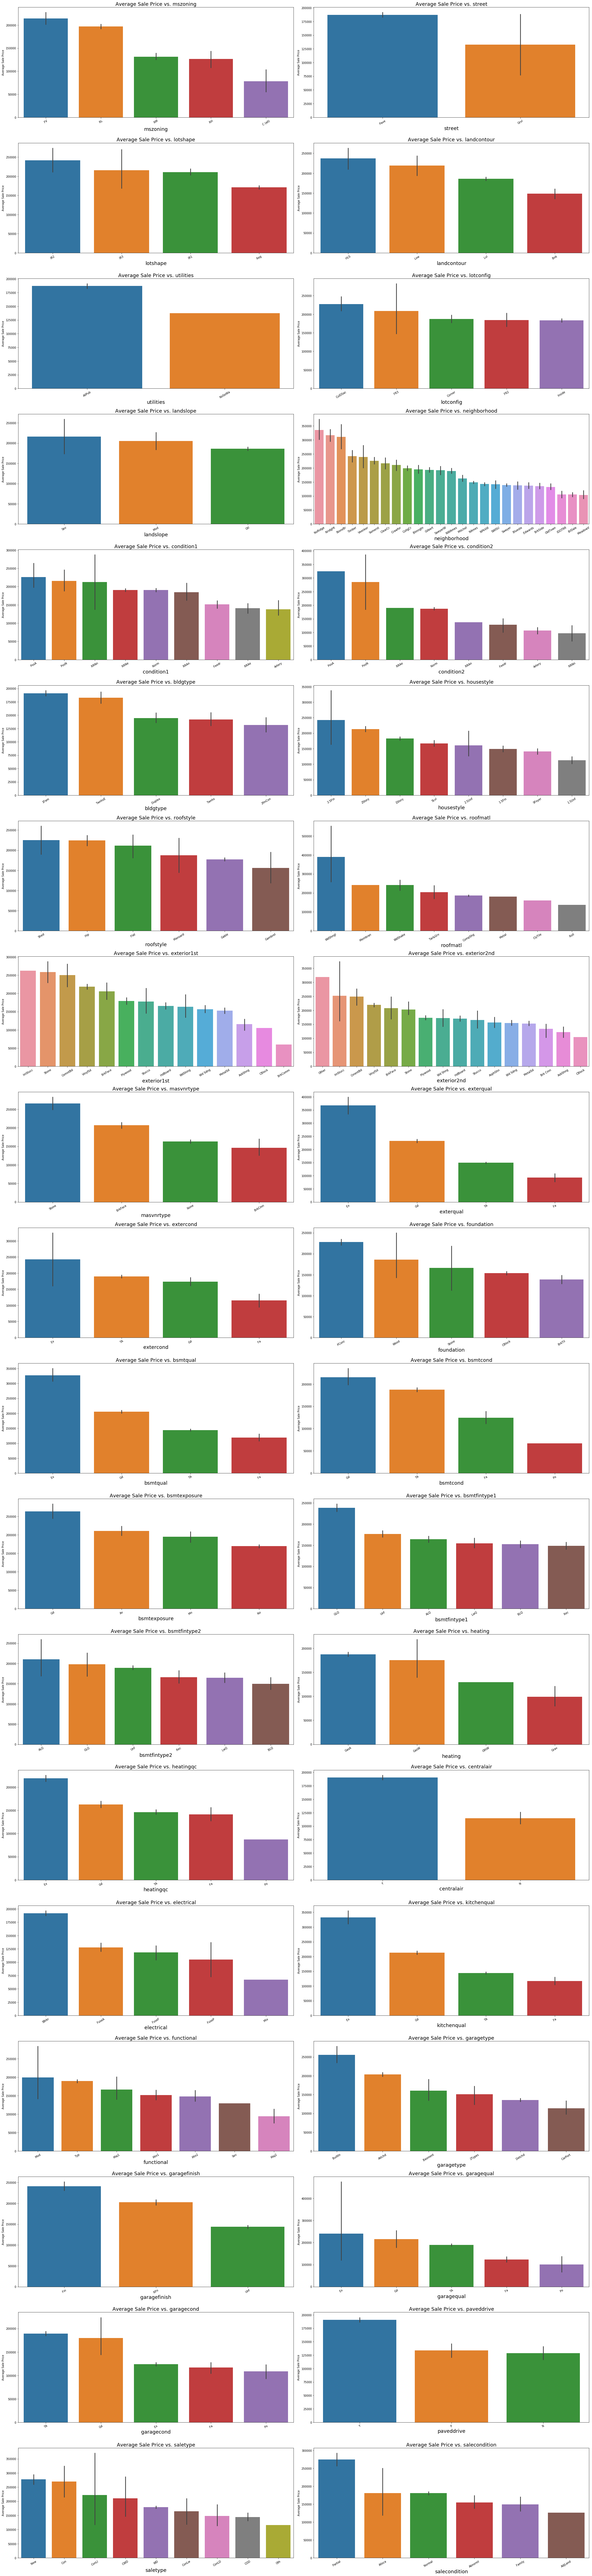

In [25]:
plt.figure(figsize=(30, 130))

for index, column in enumerate(cat_cols2):
    order = house_df_clean.groupby(column)['saleprice'].mean().sort_values(ascending = False).index
    plt.subplot(19, 2, index+1)
    sns.barplot(data = house_df_clean, x = column, y = 'saleprice', order = order)
    plt.title('Average Sale Price vs. {}'.format(column), fontsize = 18)
    plt.ylabel("Average Sale Price")
    plt.xlabel(column, fontsize = 18)
    plt.xticks(rotation = 30)

plt.tight_layout();

From the plots displayed above, the variables 'exterqual', 'kitchenqual', 'centralair', and 'mszoning' were selected for the modeling stage since they display significant variability in sale price among the levels or options

Due to the non-numeric nature of the variables just mentioned, the engineering of new features using 'One Hot Encoding' was done for each of the four variables as follows

In [26]:
house_df_clean = pd.concat([house_df_clean, pd.get_dummies(house_df_clean['exterqual'], prefix = 'exterqual_dummy', drop_first=True)], axis = 1)

house_df_clean = pd.concat([house_df_clean, pd.get_dummies(house_df_clean['kitchenqual'], prefix = 'kitchenqual_dummy', drop_first=True)], axis = 1)

house_df_clean = pd.concat([house_df_clean, pd.get_dummies(house_df_clean['centralair'], prefix = 'centrailair_dummy', drop_first=True)], axis = 1)

house_df_clean = pd.concat([house_df_clean, pd.get_dummies(house_df_clean['mszoning'], prefix = 'mszoning_dummy', drop_first=True)], axis = 1)

### Modeling - Regression

Once the independent variables were selected and prepared for the modeling evaluation and optimization, a Linear Regression model was estimated using OLS. The working dataset was splitted into a 'train' and a 'test' subsets for use during model training and model testing respectively

In [27]:
X1 = house_df_clean[['inter_overallqual_totallivarea', 'garagecars', 'totalbsmtsf', 'exterqual_dummy_Fa', 'exterqual_dummy_Gd', 'exterqual_dummy_TA', 'kitchenqual_dummy_Fa', 'kitchenqual_dummy_Gd', 'kitchenqual_dummy_TA', 'mszoning_dummy_FV', 'mszoning_dummy_RL', 'mszoning_dummy_RM', 'mszoning_dummy_RH', 'centrailair_dummy_Y']]

Y1 = house_df_clean['saleprice']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, Y1, test_size = 0.2, random_state = 465)

In order to be able to evaluate the statistical significance of the selected variables and other important metrics, the built-in OLS function available in the "statsmodel" library was used and the results summarized below. As it can be seen in the table below, our first model was able to explain around 77% of the variance in the target variable 'saleprice', with statistically significant F-statistic value of 256.2. Metrics such as AIC and BIC were reported to be 25,740 and 25,810 respectively. All selected variables with the exception of two dummy variables for the categorical variable 'mszoning' were found to be statistically significant. The dummy variables 'mszoning_dummy_RM' and 'mszoning_dummy_RH' reported p-values of 0.185 and 0.138 respectively; values which may be considered borerline significant is certain cases. Due to the intrinsic correlation dummy variables from the same categorical variable are expected to have, discarding the mentioned variables from the model is not imperative

In [28]:
X_1 = sm.add_constant(X1_train)

results_1 = sm.OLS(y1_train, X_1).fit()

results_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     256.2
Date:                Wed, 23 Oct 2019   Prob (F-statistic):               0.00
Time:                        18:34:14   Log-Likelihood:                -12854.
No. Observations:                1077   AIC:                         2.574e+04
Df Residuals:                    1062   BIC:                         2.581e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                            7.21e+04   1.75e+04      4.111      0.000    3.77e+04    1.07e+05
inter_overallqual_totallivarea     5.9615      0.265     22.472      0.000       5.441       6.482
garagecars                      2.438e+04   2348.093     10.385      0.000    1.98e+04     2.9e+04
totalbsmtsf                      -29.9786      4.539     -6.605      0.000     -38.885     -21.072
exterqual_dummy_Fa               -3.9e+04   1.79e+04     -2.180      0.029   -7.41e+04   -3899.887
exterqual_dummy_Gd              -1.96e+04   7561.764     -2.592      0.010   -3.44e+04   -4760.828
exterqual_dummy_TA             -3.077e+04   8259.403     -3.726      0.000    -4.7e+04   -1.46e+04
kitchenqual_dummy_Fa           -3.899e+04   1.11e+04     -3.527      0.000   -6.07e+04   -1.73e+04
kitchenqual_dummy_Gd           -2.544e+04   5632.182     -4.516      0.000   -3.65e+04   -1.44e+04
kitchenqual_dummy_TA           -3.621e+04   6293.860     -5.753      0.000   -4.86e+04   -2.39e+04
mszoning_dummy_FV               3.051e+04   1.55e+04      1.962      0.050       1.809     6.1e+04
mszoning_dummy_RL               3.966e+04   1.46e+04      2.719      0.007     1.1e+04    6.83e+04
mszoning_dummy_RM               1.944e+04   1.47e+04      1.327      0.185   -9315.001    4.82e+04
mszoning_dummy_RH               2.865e+04   1.93e+04      1.485      0.138   -9201.967    6.65e+04
centrailair_dummy_Y             1.926e+04   5958.801      3.233      0.001    7570.575     3.1e+04
==============================================================================
Omnibus:                      882.326   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           142014.042
Skew:                          -2.956   Prob(JB):                         0.00
Kurtosis:                      58.944   Cond. No.                     5.55e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.55e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- **Linear Regression Model #1 using OLS**

In order to obtain evaluate our model in the 'test' subset and compare its performance against the 'train'subset, sklearn LinearRegression function was used. Several common metrics for evaluation of model performances were also calculated and summarized below

In [29]:
lrm_1 = LinearRegression()

lrm_1.fit(X1_train, y1_train)

# We are making predictions here to evaluate the performance of our model using the "train" and "test" subsets
y1_preds_train = lrm_1.predict(X1_train)

y1_preds_test = lrm_1.predict(X1_test)

print("R-squared of the model using training subset is: {}".format(lrm_1.score(X1_train, y1_train)))
print("\n-----Test set statistics-----\n")
print("R-squared of the model using testing subset is: {}".format(lrm_1.score(X1_test, y1_test)))
print("Mean absolute error (MAE) of the prediction is: {}".format(mean_absolute_error(y1_test, y1_preds_test)))
print("Mean squared error (MSE) of the prediction is: {}".format(mse(y1_test, y1_preds_test)))
print("Root mean squared error (RMSE) of the prediction is: {}".format(rmse(y1_test, y1_preds_test)))
print("Mean absolute percentage error (MAPE) of the prediction is: {}".format(np.mean(np.abs((y1_test - y1_preds_test) / y1_test)) * 100))

R-squared of the model using training subset is: 0.7715286962347474

-----Test set statistics-----

R-squared of the model using testing subset is: 0.8369938944240745
Mean absolute error (MAE) of the prediction is: 22018.455614472598
Mean squared error (MSE) of the prediction is: 1201816231.8641827
Root mean squared error (RMSE) of the prediction is: 34667.22128847628
Mean absolute percentage error (MAPE) of the prediction is: 11.621313631523151


As it can be seen in the summarized results presented above, our model exhibits a better performance while explaning the variance in the target variable 'saleprice' using the 'test' subset in comparison when using the 'train' subset. This increase in performance is significant and speaks highly about the generality of the model in dealing with previously unseen data. In terms of ability to accurately predict, our model predicted 'saleprice' values with an average error of 11.6% and root mean squared error of 34,667.22. In an attempt to improve this performance, modifications were made and the results are reported below

- **Linear Regression Model #2 (include neighborhoods as numeric variable)**

In this section, a new feature was engineered and introduced into the model. The variable 'num_neigh' was created by aggregating and ranking the levels on the 'neighborhood' variable in terms of the average sale price. The neighborhood with the highest average 'saleprice' was assigned a value of 25 while the neighborhood with the lowest 'saleprice' was assigned a value of 1

In [30]:
ranked_neigh = house_df_clean.groupby('neighborhood')['saleprice'].mean().sort_values()

neigh_df = pd.DataFrame(ranked_neigh)

neigh_df['num_neigh'] = range(1, 26, 1)

neigh_df.drop('saleprice', axis = 1, inplace = True)

house_df_clean = house_df_clean.merge(neigh_df, on = 'neighborhood')

In [31]:
X2 = house_df_clean[['num_neigh', 'inter_overallqual_totallivarea', 'garagecars', 'totalbsmtsf', 'exterqual_dummy_Fa', 'exterqual_dummy_Gd', 'exterqual_dummy_TA', 'kitchenqual_dummy_Fa', 'kitchenqual_dummy_Gd', 'kitchenqual_dummy_TA', 'mszoning_dummy_FV', 'mszoning_dummy_RL', 'mszoning_dummy_RM', 'mszoning_dummy_RH', 'centrailair_dummy_Y']]

Y2 = house_df_clean['saleprice']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, Y2, test_size = 0.2, random_state = 465)

Upon the inclusion of the new 'num_neigh' variable, the Linear Regression model was fitted using the 'train' subset and evaluated using the 'test' subset. The summary of results is presented below

In [32]:
lrm_2 = LinearRegression()

lrm_2.fit(X2_train, y2_train)

# We are making predictions here to evaluate the performance of our model using the "train" and "test" subsets
y2_preds_train = lrm_2.predict(X2_train)

y2_preds_test = lrm_2.predict(X2_test)

print("R-squared of the model using training subset is: {}".format(lrm_2.score(X2_train, y2_train)))
print("\n-----Test set statistics-----\n")
print("R-squared of the model using testing subset is: {}".format(lrm_2.score(X2_test, y2_test)))
print("Mean absolute error (MAE) of the prediction is: {}".format(mean_absolute_error(y2_test, y2_preds_test)))
print("Mean squared error (MSE) of the prediction is: {}".format(mse(y2_test, y2_preds_test)))
print("Root mean squared error (RMSE) of the prediction is: {}".format(rmse(y2_test, y2_preds_test)))
print("Mean absolute percentage error (MAPE) of the prediction is: {}".format(np.mean(np.abs((y2_test - y2_preds_test) / y2_test)) * 100))

R-squared of the model using training subset is: 0.8005789120226147

-----Test set statistics-----

R-squared of the model using testing subset is: 0.8429952927682328
Mean absolute error (MAE) of the prediction is: 21274.696825660656
Mean squared error (MSE) of the prediction is: 1075490065.4293604
Root mean squared error (RMSE) of the prediction is: 32794.66519770191
Mean absolute percentage error (MAPE) of the prediction is: 11.181269571742


As it can be seen above, our modified model performed better using the when presented with the 'test' subset than when employing the 'train' subset used for fitting. On average our model was able to explain around 82% of the variance present in our full dataset. When analyzing the metrics in regards with the ability of our model to predict the target in the 'test' subset, average errors (MAPE) of 11.18% were calculated. Compared to our first model, this decrease in MAPE can be considered significant and justifies the inclusion of the 'num_neigh' variable 

- **RANdom SAmple Consensus (RANSAC) algorithm**

Since the initial exploration of the distribution of our target variable 'saleprice' indicated the presence of potential outliers, the use of the Random Sample Consensus algorithm in our regression model became an valuable alternative that would not require discarding the potential outliers from our working dataset

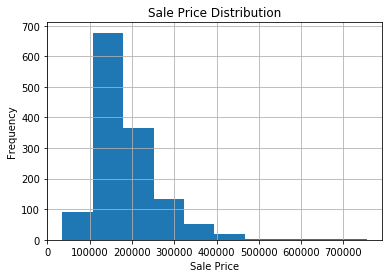

In [33]:
house_df_clean.saleprice.hist()
plt.title('Sale Price Distribution')
plt.xlabel('Sale Price')
plt.ylabel('Frequency');

As it has been described by Sebastian Raschka and Vahid Mirjalili in the book titled "Python Machine Learning" in its second edition, in general the iterative RANSAC algorithm works as follows on:

1. Selecting a random number of samples to be inliers and fit the model

2. Testing all other data points against the fitted model and adding those points that fall within a give tolerance to be inliers

3. Refitting the model using all the inliers

4. Estimating the error of the fitted model versus the inliers

5. Terminating the algorithm if the performance meets a certain user-defined treshold or if a fixed number of iterations were reached

In [34]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor (LinearRegression(), max_trials=100, min_samples=50, loss='absolute_loss', residual_threshold=70000.0, random_state=0)
ransac.fit(X2_train, y2_train)

RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
        is_data_valid=None, is_model_valid=None, loss='absolute_loss',
        max_skips=inf, max_trials=100, min_samples=50, random_state=0,
        residual_threshold=70000.0, stop_n_inliers=inf,
        stop_probability=0.99, stop_score=inf)

In [35]:
y3_preds_train = ransac.predict(X2_train)

y3_preds_test = ransac.predict(X2_test)

print("R-squared of the model using training subset is: {}".format(ransac.score(X2_train, y2_train)))
print("\n-----Test set statistics-----\n")
print("R-squared of the model using testing subset is: {}".format(ransac.score(X2_test, y2_test)))
print("Mean absolute error (MAE) of the prediction is: {}".format(mean_absolute_error(y2_test, y3_preds_test)))
print("Mean squared error (MSE) of the prediction is: {}".format(mse(y2_test, y3_preds_test)))
print("Root mean squared error (RMSE) of the prediction is: {}".format(rmse(y2_test, y2_preds_test)))
print("Mean absolute percentage error (MAPE) of the prediction is: {}".format(np.mean(np.abs((y2_test - y3_preds_test) / y2_test)) * 100))

R-squared of the model using training subset is: 0.774077415604493

-----Test set statistics-----

R-squared of the model using testing subset is: 0.8624750998428273
Mean absolute error (MAE) of the prediction is: 19951.449758339928
Mean squared error (MSE) of the prediction is: 942052416.6187384
Root mean squared error (RMSE) of the prediction is: 32794.66519770191
Mean absolute percentage error (MAPE) of the prediction is: 10.61637395586019


As it can be seen in the summary results presented above, this model significantly outperformed the two previous models based on the use of OLS as estimator. Significantly, the ability of the model to explain the variance in the target variable using the training subset (77%) was significantly outperformed when explaining the variance in the target using the testing subset (86%). Evaluating the predictive ability of the model, an RMSE value of 32,794 and MAPE of 10.61% may be considered a significant improvement upon the two first models presented

- **Ridge Regression (using dataset used for Model #2)**

In order to further optimize our model, regularized methods for regression were also evaluated using the variables used for Model #2 presented above. As necessary,  a range of possible alpha (regularization parameter lambda) values is chosen and would be evaluated as well as the use of the built-in cross-validation options offered in the sklearn package. The first method attempted is the Ridge Regression and the summarized results are presented below. This regularization method imposes an L2 penalty on the model resulting in minimization of the variance and preventing overfitting

In [36]:
alphas = [np.power(10.0, p) for p in np.arange(-10, 50, 1)]

ridge_cv = RidgeCV(alphas = alphas, cv = 5)

ridge_cv.fit(X2_train, y2_train)

y4_preds_train = ridge_cv.predict(X2_train)

y4_preds_test = ridge_cv.predict(X2_test)

print("Best alpha value is: {}\n".format(ridge_cv.alpha_))
print("R-squared of the model using the training subset is: {}\n".format(ridge_cv.score(X2_train, y2_train)))
print("\n-----Test set statistics-----\n")
print("R-squared of the model using the testing subset is: {}".format(ridge_cv.score(X2_test, y2_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y2_test, y4_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y2_test, y4_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y2_test, y4_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y2_test - y4_preds_test) / y2_test)) * 100))

Best alpha value is: 1.0

R-squared of the model using the training subset is: 0.8005005190171356


-----Test set statistics-----

R-squared of the model using the testing subset is: 0.8434791674940311
Mean absolute error of the prediction is: 21225.381287200635
Mean squared error of the prediction is: 1072175499.4543407
Root mean squared error of the prediction is: 32744.091061660893
Mean absolute percentage error of the prediction is: 11.155823011809197


As it can be seen above, the Ridge Regression method offered slightly better results that the regression using OLS, however this model was not able to outperform the RANSAC model. The optimized alpha (lambda) was found to be 1.0 

- **Least Absolute Shrinkage and Selection Operator (LASSO) Regression (using dataset used for Model #2)**

As a third alternative model, the LASSO regression method was evaluated. The LASSO regression method is also called a L1 regularization

In [37]:
lasso_cv = LassoCV(alphas = alphas, cv = 5)

lasso_cv.fit(X2_train, y2_train)

y5_preds_train = lasso_cv.predict(X2_train)

y5_preds_test = lasso_cv.predict(X2_test)

print("Best alpha value is: {}\n".format(lasso_cv.alpha_))
print("R-squared of the model using the training subset is: {}\n".format(lasso_cv.score(X2_train, y2_train)))
print("\n-----Test set statistics-----\n")
print("R-squared of the model using the testing subset is: {}".format(lasso_cv.score(X2_test, y2_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y2_test, y5_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y2_test, y5_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y2_test, y5_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y2_test - y5_preds_test) / y2_test)) * 100))

Best alpha value is: 10.0

R-squared of the model using the training subset is: 0.8005614284985526


-----Test set statistics-----

R-squared of the model using the testing subset is: 0.8430978857471046
Mean absolute error of the prediction is: 21266.58590052184
Mean squared error of the prediction is: 1074787298.413613
Root mean squared error of the prediction is: 32783.948792261326
Mean absolute percentage error of the prediction is: 11.176460545923852


From the results above, the LASSO method produced a model capable of explaining 80% of the variance in the target variable using the training dataset while improving this figure using the testing subset (84%). In terms of predictions of the target, this new model was not able to perform better than the model using Ridge regression method but was slightly better than the model using OLS estimation approach. Once again this new model fell short when compared to the RANSAC model based on every metric of error employed

- **ElasticNet Regression (using dataset used for Model #2)**

In a new attempt to optimize our original OLS model (Model #2), a new model using ElasticNet regression algorithm was evaluated. The ElasticNet regression can be seen as a combination of both Ridge and LASSO regressions by combining L1 and L2 regularization in its cost function

In [38]:
elasticnet_cv = ElasticNetCV(alphas = alphas, cv = 5)

elasticnet_cv.fit(X2_train, y2_train)

y6_preds_train = elasticnet_cv.predict(X2_train)

y6_preds_test = elasticnet_cv.predict(X2_test)

print("Best alpha value is: {}\n".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}\n".format(elasticnet_cv.score(X2_train, y2_train)))
print("\n-----Test set statistics-----\n")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X2_test, y2_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y2_test, y6_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y2_test, y6_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y2_test, y6_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y2_test - y6_preds_test) / y2_test)) * 100))

Best alpha value is: 0.001

R-squared of the model in training set is: 0.8005533289875729


-----Test set statistics-----

R-squared of the model in test set is: 0.8432788654927215
Mean absolute error of the prediction is: 21247.351402919187
Mean squared error of the prediction is: 1073547578.1409754
Root mean squared error of the prediction is: 32765.0359093497
Mean absolute percentage error of the prediction is: 11.167017759613156


As it can be seen in the results presented above, the use of the ElasticNet regression model in our data report error metrics somehow in between the values reported from using Ridge and LASSO regression methods. In all cases when a regularization regression approach was evaluated the resulting methods outperform the original OLS regression method used in Model #2, suggesting that penalties imposed in large coefficients and complexity of the model result in optimization of the model

### Summary of Modelling Results

In order to offer a summarized view of the optimization efforts carried during the modelling phase of this project, a summary table was prepared and presented below

In [39]:
model_1 = [lrm_1.score(X1_train, y1_train), lrm_1.score(X1_test, y1_test), mean_absolute_error(y1_test, y1_preds_test), mse(y1_test, y1_preds_test), rmse(y1_test, y1_preds_test), np.mean(np.abs((y1_test - y1_preds_test) / y1_test)) * 100]

model_2 = [lrm_2.score(X2_train, y2_train), lrm_2.score(X2_test, y2_test), mean_absolute_error(y2_test, y2_preds_test), mse(y2_test, y2_preds_test), rmse(y2_test, y2_preds_test), np.mean(np.abs((y2_test - y2_preds_test) / y2_test)) * 100]

model_3 = [ransac.score(X2_train, y2_train), ransac.score(X2_test, y2_test), mean_absolute_error(y2_test, y3_preds_test), mse(y2_test, y3_preds_test), rmse(y2_test, y3_preds_test), np.mean(np.abs((y2_test - y3_preds_test) / y2_test)) * 100]

model_4 = [ridge_cv.score(X2_train, y2_train), ridge_cv.score(X2_test, y2_test), mean_absolute_error(y2_test, y4_preds_test), mse(y2_test, y4_preds_test), rmse(y2_test, y4_preds_test), np.mean(np.abs((y2_test - y4_preds_test) / y2_test)) * 100]

model_5 = [lasso_cv.score(X2_train, y2_train), lasso_cv.score(X2_test, y2_test), mean_absolute_error(y2_test, y5_preds_test), mse(y2_test, y5_preds_test), rmse(y2_test, y5_preds_test), np.mean(np.abs((y2_test - y5_preds_test) / y2_test)) * 100]

model_6 = [elasticnet_cv.score(X2_train, y2_train), elasticnet_cv.score(X2_test, y2_test), mean_absolute_error(y2_test, y6_preds_test), mse(y2_test, y6_preds_test), rmse(y2_test, y6_preds_test), np.mean(np.abs((y2_test - y6_preds_test) / y2_test)) * 100]

summary_df = pd.DataFrame([model_1, model_2, model_3, model_4, model_5, model_6], index = ['linear_1', 'linear_2', 'ransac', 'ridge', 'lasso', 'elasticnet'], columns = ['R-sqd (training)', 'R-sqd (testing)', 'MAE', 'MSE', 'RMSE', 'MAPE'])

As it may be seen in the table below, the model based on the use of the RANSAC algorithm significantly outperformed all other models by reducing every error metric calculated. The bigger difference seen between the R-squared values reported using the 'train' and 'test' subsets may be expected due to the exclusive use of inliers to fit the model. Also, the use of regularization regression methods resulted in improved models in comparison to traditional OLS regression estimator

In [40]:
summary_df

,R-sqd (training),R-sqd (testing),MAE,MSE,RMSE,MAPE
linear_1,0.771529,0.836994,22018.455614,1.201816e+09,34667.221288,11.621314
linear_2,0.800579,0.842995,21274.696826,1.075490e+09,32794.665198,11.181270
ransac,0.774077,0.862475,19951.449758,9.420524e+08,30692.872407,10.616374
ridge,0.800501,0.843479,21225.381287,1.072175e+09,32744.091062,11.155823
lasso,0.800561,0.843098,21266.585901,1.074787e+09,32783.948792,11.176461
elasticnet,0.800553,0.843279,21247.351403,1.073548e+09,32765.035909,11.167018


### Use of Other Variables not Present in the Original Dataset

In an effort to complement our working dataset with other variables that might be correlated to the variance present in the target variable 'saleprice', research on the average mortgage interest rates during 2006-2010 was conducted. The reported rates were then included in our selected variables and the RANSAC regression algorithm (best performing model) evaluated as described in the previous section

In [41]:
yrsold = [2006, 2007, 2008, 2009, 2010]

rates = [6.41, 6.34, 6.03, 5.04, 4.69]

rates_df = pd.DataFrame(yrsold, columns = ['yrsold'])

rates_df['rate'] = rates

house_df_clean = house_df_clean.merge(rates_df, on = 'yrsold')

In [42]:
X3 = house_df_clean[['rate', 'num_neigh', 'inter_overallqual_totallivarea', 'garagecars', 'totalbsmtsf', 'exterqual_dummy_Fa', 'exterqual_dummy_Gd', 'exterqual_dummy_TA', 'kitchenqual_dummy_Fa', 'kitchenqual_dummy_Gd', 'kitchenqual_dummy_TA', 'mszoning_dummy_FV', 'mszoning_dummy_RL', 'mszoning_dummy_RM', 'mszoning_dummy_RH', 'centrailair_dummy_Y']]

Y3 = house_df_clean['saleprice']

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, Y3, test_size = 0.2, random_state = 465)

Upon updating the list of selected independent variables, the RANSAC algorithm was evaluated as follows

In [43]:
ransac_rate = RANSACRegressor (LinearRegression(), max_trials=100, min_samples=50, loss='absolute_loss', residual_threshold=70000.0, random_state=0)
ransac.fit(X3_train, y3_train)

RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
        is_data_valid=None, is_model_valid=None, loss='absolute_loss',
        max_skips=inf, max_trials=100, min_samples=50, random_state=0,
        residual_threshold=70000.0, stop_n_inliers=inf,
        stop_probability=0.99, stop_score=inf)

In [44]:
y7_preds_train = ransac.predict(X3_train)

y7_preds_test = ransac.predict(X3_test)

print("R-squared of the model using training subset is: {}".format(ransac.score(X3_train, y3_train)))
print("\n-----Test set statistics-----\n")
print("R-squared of the model using testing subset is: {}".format(ransac.score(X3_test, y3_test)))
print("Mean absolute error (MAE) of the prediction is: {}".format(mean_absolute_error(y3_test, y7_preds_test)))
print("Mean squared error (MSE) of the prediction is: {}".format(mse(y3_test, y7_preds_test)))
print("Root mean squared error (RMSE) of the prediction is: {}".format(rmse(y3_test, y7_preds_test)))
print("Mean absolute percentage error (MAPE) of the prediction is: {}".format(np.mean(np.abs((y3_test - y7_preds_test) / y3_test)) * 100))

R-squared of the model using training subset is: 0.7782897807854203

-----Test set statistics-----

R-squared of the model using testing subset is: 0.8801535028284082
Mean absolute error (MAE) of the prediction is: 18957.757267833964
Mean squared error (MSE) of the prediction is: 727786593.811031
Root mean squared error (RMSE) of the prediction is: 26977.52015680891
Mean absolute percentage error (MAPE) of the prediction is: 11.202115316684456


The results above suggest that the new model including the mortgage interest rates ('rate') generated prediction error metrics that significantly outperform a similar model applied in data not including the mentioned variable. However, the values reported for the Mean Absolute Percentage Error (MAPE) were the highest among all the models compared